In [1]:
import numpy as np
import os
import ipynbname
script_dir = os.getcwd()
filename = ipynbname.name()

from sde.SDE_ARFF_lib import (
    SDEARFFTrain,
    NNHyperparameters
)

from sde.experiment_reports_owen import (
    PlotResults,
    sample_data
)

%load_ext autoreload
%autoreload 2


2025-06-16 16:49:35.431797: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-16 16:49:35.440959: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.6/lib64::/usr/lib/x86_64-linux-gnu
2025-06-16 16:49:35.440994: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# notebook parameters
n_dimensions = 3
step_size = .01
n_pts = 10000
n_subsample = 1000

random_seed = 1

In [3]:
# network parameters
validation_split = .1
ARFF_validation_split = .1

drift_param = NNHyperparameters(K=2**7, 
                                M_min=20,
                                M_max=500,
                                lambda_reg=2e-6,
                                gamma=1,
                                delta=0.02,
                                name='drift')
diff_param = NNHyperparameters(K=drift_param.K,
                               M_min=drift_param.M_min,
                               M_max=drift_param.M_max,
                               lambda_reg=drift_param.lambda_reg,
                               gamma=drift_param.gamma,
                               delta=drift_param.delta,
                               name='diff')


In [4]:
# EXAMPLE 2
def f_1(x):
    A = 0
    B = np.array([[-1], [0], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    f = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return f


def f_2(x):
    A = 0
    B = np.array([[0], [-1], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    f = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return f


def f_3(x):
    A = 0
    B = np.array([[0], [0], [-1]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    f = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return f


def true_drift(x):
    drift = np.transpose(np.array([f_1(x), f_2(x), f_3(x)]))
    return drift


def sigma_11(x):
    A = 0.02045836
    B = np.array([[0], [0], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def sigma_12(x):
    A = -0.03502162
    B = np.array([[0], [0], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def sigma_13(x):
    A = -0.02678421
    B = np.array([[0], [0], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def sigma_22(x):
    A = 0.06355898
    B = np.array([[0], [0], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def sigma_23(x):
    A = 0.02981971
    B = np.array([[0], [0], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def sigma_33(x):
    A = 0.12453806
    B = np.array([[0], [0], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def true_diffusion(x):
    diffusion = np.abs(np.transpose(np.array([[sigma_11(x), sigma_12(x), sigma_13(x)], [sigma_12(x), sigma_22(x), sigma_23(x)], [sigma_13(x), sigma_23(x), sigma_33(x)]])))
    return diffusion


def true_drift_diffusion(x):
    return true_drift(x), true_diffusion(x)


print(true_diffusion((0,0,0)))

xlim = np.array([[-1, 1], [-1, 1], [-1, 1]])

step_sizes = np.zeros((n_pts, 1)) + step_size


[[0.02045836 0.03502162 0.02678421]
 [0.03502162 0.06355898 0.02981971]
 [0.02678421 0.02981971 0.12453806]]


In [5]:
# train networks
No_of_tests = 1
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    rng = np.random.default_rng(random_seed + i)

    # generate data
    x_data, y_data, _ = sample_data(true_drift_diffusion, step_size, n_pts, n_subsample, rng, xlim)

    # build network
    SAT = SDEARFFTrain(n_dimensions=n_dimensions, diff_type="symmetric", rng=rng, resampling=True)

    # train network
    hist = SAT.train_model(drift_param, diff_param, true_drift, true_diffusion, x_data, y_data, step_sizes=step_sizes, validation_split=validation_split, ARFF_validation_split=ARFF_validation_split, plot=False)
    
    training_time[i] = hist.history["training_time"]
    val_loss[i] = hist.history["val_loss"]


drift epoch: 20
diff epoch: 26


2025-06-16 16:50:33.001543: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.6/lib64::/usr/lib/x86_64-linux-gnu
2025-06-16 16:50:33.001732: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.6/lib64::/usr/lib/x86_64-linux-gnu
2025-06-16 16:50:33.001809: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.6/lib64::/usr/lib/x86_64-linux-gnu
2025-06-16 16:50:33.

Drift RMSE: 0.026992676974278033
Diffusion RMSE: 0.001461261117179193
Observed loss: -16.093814101013994
Observed validation loss: -16.04398105829171
True loss: -14.250082128314222
Training time: 11.588073968887329


Theoretical mean min loss: -16.169772177718716
Loss standard deviation: 0.012909944487358056
Validation loss standard deviation: 0.03872983346207417
figures_per_row 3


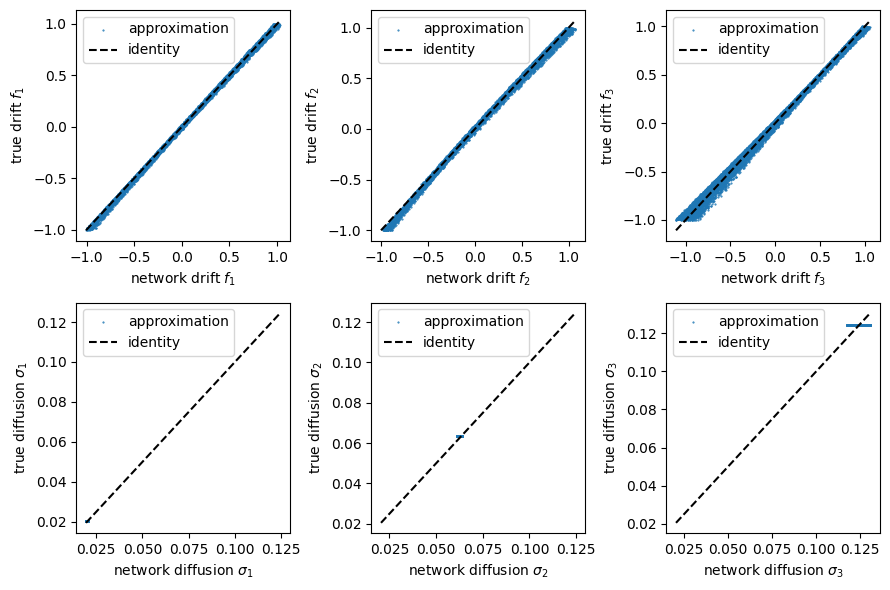

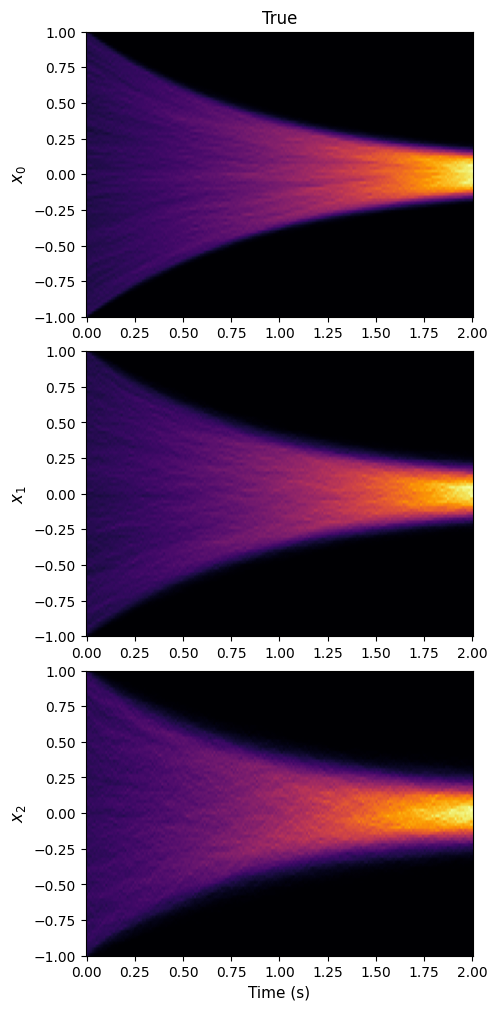

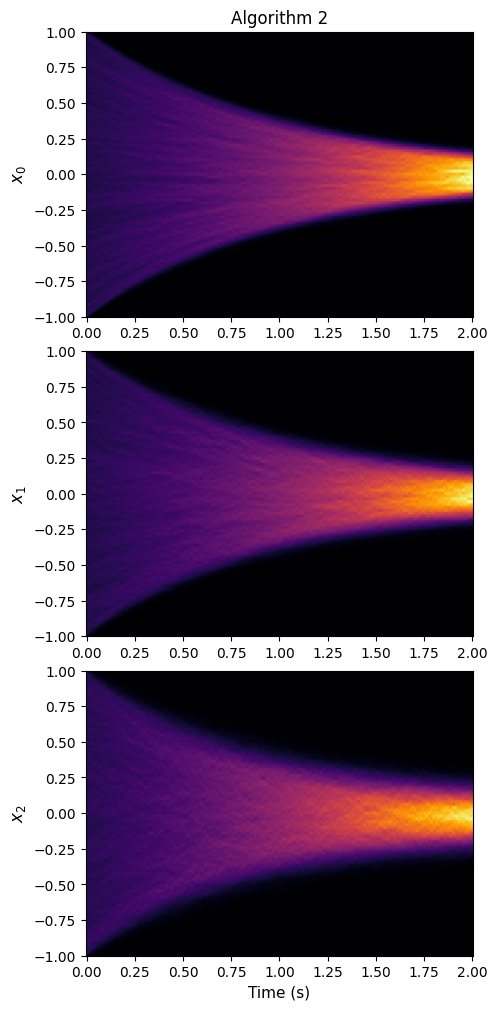

In [6]:
# display and save plots
PR = PlotResults(script_dir=script_dir, filename=filename, n_subsample=n_subsample)

# calculate theoretical mean min loss (integral over loss function across input domain)
PR.mean_min_loss(true_diffusion, n_pts, validation_split, step_size, xlim, save=False)

if No_of_tests > 1:
    PR.loss_stats(training_time, val_loss, save=True)

PR.plot_results_functions(SAT.drift_diffusion, true_drift_diffusion, x_data, save=False)

time = 200*step_size
PR.plot_histogram(true_drift_diffusion, step_size, time, rng, xlim, name='True', save=False)
PR.plot_histogram(SAT.drift_diffusion, step_size, time, rng, xlim, name='Algorithm 2', save=True)
